# Under the Hood: Training a Digit Classifier

In [13]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

### Organising and accessing data via Path

Download and untar data using fastai

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

Setup base path

In [4]:
Path.BASE_PATH = path

Leverage linux commands

In [5]:
path.ls()

[Path('valid'), Path('labels.csv'), Path('train')]

In [6]:
(path/'train').ls()

[Path('train/7'), Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls()
sevens = (path/'train'/'7').ls()

### Preparing Image data with Pillow

How do we open up images?

Open image using Pillow

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

How do we make the images usable to a model?

In [9]:
img3_t = tensor(im3)[4:15, 4:22] # convert to tensor

How do we visualise the images?

In [10]:
df = pd.DataFrame(img3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,132,161,221,254,254,186,136,7,0,0,0,0
1,0,0,0,34,164,230,211,206,148,148,156,206,254,157,0,0,0,0
2,0,0,70,240,239,179,25,0,0,0,0,0,178,206,0,0,0,0
3,0,34,232,160,25,0,0,0,0,0,0,0,195,206,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,7,170,254,90,0,0,0,0
5,0,0,0,0,0,0,0,0,0,26,166,253,124,2,0,0,0,0
6,0,0,0,0,0,0,0,0,83,190,234,104,0,0,0,0,0,0
7,0,0,0,0,0,0,0,134,254,202,54,0,0,0,0,0,0,0
8,0,0,0,0,0,38,221,254,254,254,211,161,136,57,0,0,0,0
9,0,0,0,0,26,230,215,139,115,64,140,206,220,249,180,47,0,0


Collect images so they are ready to be processed

In [11]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

### Tensors

What does rank mean?

The rank of a tensor is the number of dimensions

To harness the power of the pytorch, we need to go a step further and combine the image tensors into one big tensor. A rank 3 tensor.

In [12]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape, stacked_threes.ndim

(torch.Size([6131, 28, 28]), 3)

In [13]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_sevens.shape, stacked_sevens.ndim

(torch.Size([6265, 28, 28]), 3)

A rule of thumb, when calculating things such as the mean over tensors, is cast integer types to float types.

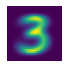

In [14]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

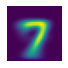

In [15]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

### Measuring distance

#### Mean Absolute Error

L1 norm or mean of the absolute value of differences.

In [16]:
a_3 = stacked_threes[0]

In [17]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_abs

tensor(0.1144)

#### Root Mean Squared Error (RMSE)

L2 norm or mean of the square of differences take the square root. 

In [18]:
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_sqr

tensor(0.2067)

In [19]:
a_7 = stacked_sevens[0]
dist_7_abs = (a_7 - mean7).abs().mean()
dist_3_abs = (a_7 - mean3).abs().mean()
dist_7_abs, dist_3_abs

(tensor(0.1001), tensor(0.1528))

In [20]:
(dist_7_abs > dist_3_abs) == 0 # Is it a 7? Yes, woohoo!

tensor(True)

In [21]:
def mnist_dist(a, b): return (a - b).abs().mean((-1,-2))

In [22]:
def is_7(x): return mnist_dist(x, mean7) < mnist_dist(x, mean3)

In [23]:
is_7(a_3), is_7(a_7)

(tensor(False), tensor(True))

### L1 Norm vs. L2 Norm

L2 norm penalises bigger mistakes (outliers) and will be more lenient of smaller mistakes when compared against the L1 norm. For example:

In [24]:
tensor([0, 10, 1, 3]).float().abs().mean()

tensor(3.5000)

In [25]:
(tensor([0, 10, 1, 3]).float()**2).mean().sqrt()

tensor(5.2440)

### Vectorization vs. Broadcasting

**Broadcasting** is the computationally efficient means of operating with two tensors of unequal size.

In [26]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

In [27]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # -1, -2 grabs image dimensions
mnist_distance(a_3, mean3)

tensor(0.1144)

In [28]:
valid_3_tens.shape, mean3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

In [29]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

Instead of complaining about the tensors being of different sizes, broadcasting calculates the distance between all images in the validation dataset and the "ideal" mean 3. In return, a tensor the length of the index of the validation dataset is given (1010 images).

**Performance**

1. PyTorch does not copy the mean 3 tensor 1,010 times. It pretends to without allocating additional memory.
2. It does this whole calculation using C (or even better using a GPU, in CUDA, the equivalent of C on the GPU.)

**Vectorization** on the other hand is a computationally efficient means of operating with two tensors or arrays of the same size. For example, two arrays/vectors can be added together on an element-wise basis. 

In [30]:
a = np.array([1, 2, 3, 4, 5])

In [31]:
b = np.array([1, 1, 1, 5, 1])

In [32]:
a + b

array([2, 3, 4, 9, 6])

### Stochastic Gradient Descent

1) Initialise parameters

2) Make predictions

3) Calculate the loss

4) Calculate the gradient of the loss with respect to the weights

5) Step the weights (backpropogation)

6) Repeat the process

7) Stop

### Sigmoid

The sigmoid function always gives an output between 0 and 1. 

$$\Large Sigmoid = \frac{1}{1+e^{-x}}$$

In [15]:
def sigmoid(x): return 1/(1+torch.exp(-x))

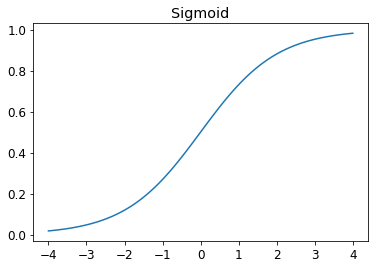

In [11]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [38]:
torch.sigmoid(Tensor([0, -1566]))

tensor([0.5000, 0.0000])

Observations:
* When x is 0, y = 0.5
* When x is -1566 = 0

*High School Math Flashback: e to the x or $\large e^x$ is often referred to as the exponential function.*

$e = 2.718281828459045 ...$

Exponential growth shows greater rates of increase over time. Whereas exponential decay - being the inverse - shows lesser rates of decrease over time.

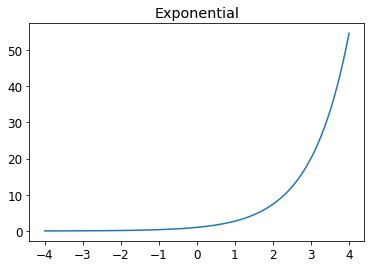

In [39]:
# Exponential Growth
plot_function(torch.exp, title='Exponential', min=-4, max=4)

In [40]:
# Exponential Decay
def exp_neg(x): return torch.exp(-x)

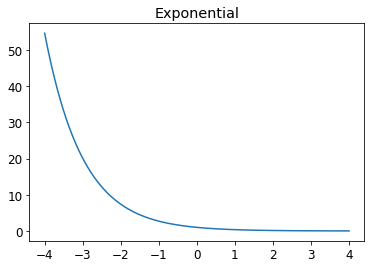

In [41]:
plot_function(exp_neg, title='Exponential', min=-4, max=4)